# 汽车数据聚类分析
## 1.项目背景说明

    针对车辆销售数据集，进行聚类分析，观察车辆可以分为几类，同时，针对新上市的车型进行定位分析，以便可以评估新车型的定价策略是否合理，同时针对合适的消费群体进行相应的营销设计
    
    数据集的情况：
    汽车类别字段用来划分轿车和卡车，轿车的值为0，卡车的值为1
    partition字段用来划分新车型和旧车型，新车型的值为1，旧车型的值为0
    
    分析思路：
    先针对旧车型进行聚类分析，观察旧车型可以归为哪几组
    再利用构建好的聚类模型，对新车型进行分类预测，观察新车型可以归为哪一组，以便找到相应的竞争对手，评估定价策略，进行营销设计

## 2.载入库和模块

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

import warnings
warnings.filterwarnings('ignore')

# 导入KMeans相关模块
from sklearn.cluster import KMeans     # KMeans算法
from sklearn.model_selection import train_test_split
import sklearn.metrics
from sklearn import preprocessing  # 数据预处理

## 3.载入数据，做基本的观察

In [3]:
# df_car = pd.read_excel('data/car_sales.xlsx')
df_car = pd.read_csv('./data/car_sales1.csv')

In [4]:
df_car.head()

,制造商,型号,销售（千辆）,4年转售价值,汽车类别,价格（千元）,发动机尺寸,马力,轴距,车宽,车长,整车重量,油箱容量,燃油效率,ln(销售),partition
0,Acura,Integra,16.92,16.36,0.0,21.50,1.8,140.0,101.2,67.3,172.4,2.64,13.2,28.0,2.83,0
1,Acura,TL,39.38,19.88,0.0,28.40,3.2,225.0,108.1,70.3,192.9,3.52,17.2,25.0,3.67,0
2,Acura,CL,14.11,18.23,0.0,NaN,3.2,225.0,106.9,70.6,192.0,3.47,17.2,26.0,2.65,0
3,Acura,RL,8.59,29.73,0.0,42.00,3.5,210.0,114.6,71.4,196.6,3.85,18.0,22.0,2.15,0
4,Audi,A4,20.40,22.26,0.0,23.99,1.8,150.0,102.6,68.2,178.0,3.00,16.4,27.0,3.02,0


In [5]:
df_car.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159 entries, 0 to 158
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   制造商        157 non-null    object 
 1   型号         159 non-null    object 
 2   销售（千辆）     157 non-null    float64
 3   4年转售价值     121 non-null    float64
 4   汽车类别       157 non-null    float64
 5   价格（千元）     157 non-null    float64
 6   发动机尺寸      158 non-null    float64
 7   马力         158 non-null    float64
 8   轴距         158 non-null    float64
 9   车宽         158 non-null    float64
 10  车长         158 non-null    float64
 11  整车重量       157 non-null    float64
 12  油箱容量       158 non-null    float64
 13  燃油效率       156 non-null    float64
 14  ln(销售)     157 non-null    object 
 15  partition  159 non-null    int64  
dtypes: float64(12), int64(1), object(3)
memory usage: 20.0+ KB


考虑用来进行聚类的数据特征主要是：汽车类别和相关的技术指标（从发动机尺寸到燃油效率）  
从info可以看到，数据集存在一定的缺失情况，需要先进行处理

In [6]:
df_car

,制造商,型号,销售（千辆）,4年转售价值,汽车类别,价格（千元）,发动机尺寸,马力,轴距,车宽,车长,整车重量,油箱容量,燃油效率,ln(销售),partition
0,Acura,Integra,16.92,16.36,0.0,21.50,1.8,140.0,101.2,67.3,172.4,2.64,13.2,28.0,2.83,0
1,Acura,TL,39.38,19.88,0.0,28.40,3.2,225.0,108.1,70.3,192.9,3.52,17.2,25.0,3.67,0
2,Acura,CL,14.11,18.23,0.0,NaN,3.2,225.0,106.9,70.6,192.0,3.47,17.2,26.0,2.65,0
3,Acura,RL,8.59,29.73,0.0,42.00,3.5,210.0,114.6,71.4,196.6,3.85,18.0,22.0,2.15,0
4,Audi,A4,20.40,22.26,0.0,23.99,1.8,150.0,102.6,68.2,178.0,3.00,16.4,27.0,3.02,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154,Volvo,V70,17.53,NaN,0.0,28.80,2.4,168.0,104.9,69.3,186.2,3.26,17.9,25.0,2.86,0
155,Volvo,C70,3.49,NaN,0.0,45.50,2.3,236.0,104.9,71.5,185.7,3.60,18.5,23.0,1.25,0
156,Volvo,S80,18.97,NaN,0.0,36.00,2.9,201.0,109.9,72.1,189.8,3.60,21.1,24.0,2.94,0
157,NaN,newCar,NaN,NaN,NaN,21.50,1.5,76.0,106.3,67.9,175.0,2.93,11.9,46.0,NaN,1


In [7]:
df_car.tail(2)

,制造商,型号,销售（千辆）,4年转售价值,汽车类别,价格（千元）,发动机尺寸,马力,轴距,车宽,车长,整车重量,油箱容量,燃油效率,ln(销售),partition
157,NaN,newCar,NaN,NaN,NaN,21.5,1.5,76.0,106.3,67.9,175.0,2.93,11.9,46.0,NaN,1
158,NaN,newTruck,NaN,NaN,NaN,34.2,3.5,167.0,109.8,75.2,188.4,4.51,17.2,26.0,NaN,1


通过观察新车型的数据可以发现，两辆新车的技术指标没有缺失，汽车类别可以根据型号进行填补，因此，需要进行缺失值处理的数据主要是旧车型的数据

## 4.数据提取与处理
### 4.1 提取旧车型数据

In [8]:
df_car.loc[df_car.partition == 0]

,制造商,型号,销售（千辆）,4年转售价值,汽车类别,价格（千元）,发动机尺寸,马力,轴距,车宽,车长,整车重量,油箱容量,燃油效率,ln(销售),partition
0,Acura,Integra,16.92,16.36,0.0,21.50,1.8,140.0,101.2,67.3,172.4,2.64,13.2,28.0,2.83,0
1,Acura,TL,39.38,19.88,0.0,28.40,3.2,225.0,108.1,70.3,192.9,3.52,17.2,25.0,3.67,0
2,Acura,CL,14.11,18.23,0.0,NaN,3.2,225.0,106.9,70.6,192.0,3.47,17.2,26.0,2.65,0
3,Acura,RL,8.59,29.73,0.0,42.00,3.5,210.0,114.6,71.4,196.6,3.85,18.0,22.0,2.15,0
4,Audi,A4,20.40,22.26,0.0,23.99,1.8,150.0,102.6,68.2,178.0,3.00,16.4,27.0,3.02,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152,Volvo,V40,3.55,NaN,0.0,24.40,1.9,160.0,100.5,67.6,176.6,3.04,15.8,25.0,1.27,0
153,Volvo,S70,15.25,NaN,0.0,27.50,2.4,168.0,104.9,69.3,185.9,3.21,17.9,25.0,2.72,0
154,Volvo,V70,17.53,NaN,0.0,28.80,2.4,168.0,104.9,69.3,186.2,3.26,17.9,25.0,2.86,0
155,Volvo,C70,3.49,NaN,0.0,45.50,2.3,236.0,104.9,71.5,185.7,3.60,18.5,23.0,1.25,0


In [9]:
df_old_car = df_car.loc[df_car.partition == 0]

In [10]:
df_old_car.info()

<class 'pandas.core.frame.DataFrame'>
Index: 157 entries, 0 to 156
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   制造商        157 non-null    object 
 1   型号         157 non-null    object 
 2   销售（千辆）     157 non-null    float64
 3   4年转售价值     121 non-null    float64
 4   汽车类别       157 non-null    float64
 5   价格（千元）     155 non-null    float64
 6   发动机尺寸      156 non-null    float64
 7   马力         156 non-null    float64
 8   轴距         156 non-null    float64
 9   车宽         156 non-null    float64
 10  车长         156 non-null    float64
 11  整车重量       155 non-null    float64
 12  油箱容量       156 non-null    float64
 13  燃油效率       154 non-null    float64
 14  ln(销售)     157 non-null    object 
 15  partition  157 non-null    int64  
dtypes: float64(12), int64(1), object(3)
memory usage: 20.9+ KB


观察旧车型数据的缺失情况

In [11]:
df_old_car.isnull().sum().sort_values(ascending = False)

4年转售价值       36
燃油效率          3
价格（千元）        2
整车重量          2
发动机尺寸         1
马力            1
轴距            1
车宽            1
车长            1
油箱容量          1
制造商           0
型号            0
销售（千辆）        0
汽车类别          0
ln(销售)        0
partition     0
dtype: int64

### 4.2 提取相关特征字段并进行简单的清洗

In [12]:
df_old_car.columns

Index(['制造商', '型号', '销售（千辆）', '4年转售价值', '汽车类别', '价格（千元）', '发动机尺寸', '马力', '轴距',
       '车宽', '车长', '整车重量', '油箱容量', '燃油效率', 'ln(销售)', 'partition'],
      dtype='object')

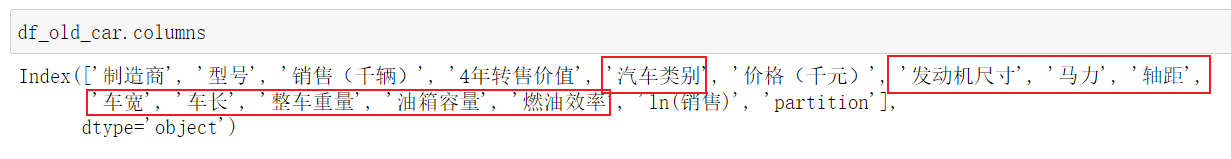

In [13]:
df_old_car[df_old_car.columns[4:-2]].drop(columns = '价格（千元）')

,汽车类别,发动机尺寸,马力,轴距,车宽,车长,整车重量,油箱容量,燃油效率
0,0.0,1.8,140.0,101.2,67.3,172.4,2.64,13.2,28.0
1,0.0,3.2,225.0,108.1,70.3,192.9,3.52,17.2,25.0
2,0.0,3.2,225.0,106.9,70.6,192.0,3.47,17.2,26.0
3,0.0,3.5,210.0,114.6,71.4,196.6,3.85,18.0,22.0
4,0.0,1.8,150.0,102.6,68.2,178.0,3.00,16.4,27.0
...,...,...,...,...,...,...,...,...,...
152,0.0,1.9,160.0,100.5,67.6,176.6,3.04,15.8,25.0
153,0.0,2.4,168.0,104.9,69.3,185.9,3.21,17.9,25.0
154,0.0,2.4,168.0,104.9,69.3,186.2,3.26,17.9,25.0
155,0.0,2.3,236.0,104.9,71.5,185.7,3.60,18.5,23.0


In [14]:
df_km = df_old_car[df_old_car.columns[4:-2]].drop(columns = '价格（千元）')
# 提取相关指标，构建用来进行聚类分析的数据集

In [15]:
df_km.head()

,汽车类别,发动机尺寸,马力,轴距,车宽,车长,整车重量,油箱容量,燃油效率
0,0.0,1.8,140.0,101.2,67.3,172.4,2.64,13.2,28.0
1,0.0,3.2,225.0,108.1,70.3,192.9,3.52,17.2,25.0
2,0.0,3.2,225.0,106.9,70.6,192.0,3.47,17.2,26.0
3,0.0,3.5,210.0,114.6,71.4,196.6,3.85,18.0,22.0
4,0.0,1.8,150.0,102.6,68.2,178.0,3.00,16.4,27.0


In [16]:
df_km.info()

<class 'pandas.core.frame.DataFrame'>
Index: 157 entries, 0 to 156
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   汽车类别    157 non-null    float64
 1   发动机尺寸   156 non-null    float64
 2   马力      156 non-null    float64
 3   轴距      156 non-null    float64
 4   车宽      156 non-null    float64
 5   车长      156 non-null    float64
 6   整车重量    155 non-null    float64
 7   油箱容量    156 non-null    float64
 8   燃油效率    154 non-null    float64
dtypes: float64(9)
memory usage: 12.3 KB


In [17]:
df_km.isnull().sum()

汽车类别     0
发动机尺寸    1
马力       1
轴距       1
车宽       1
车长       1
整车重量     2
油箱容量     1
燃油效率     3
dtype: int64

如何提取出带有缺失值的记录？

In [18]:
df_km.isnull().any()
# 返回结果是一个布尔型的Series，表示的是每个列是否存在缺失

汽车类别     False
发动机尺寸     True
马力        True
轴距        True
车宽        True
车长        True
整车重量      True
油箱容量      True
燃油效率      True
dtype: bool

In [19]:
df_km.isnull().T.any()
# 返回一个布尔型的Series，索引是行的位置索引，值是该行数据是否缺失

0      False
1      False
2      False
3      False
4      False
       ...  
152    False
153    False
154    False
155    False
156    False
Length: 157, dtype: bool

In [20]:
df_km.isnull().T.any().sum()

4

In [21]:
# 查看带有缺失值的记录
df_km.loc[df_km.isnull().T.any()]

,汽车类别,发动机尺寸,马力,轴距,车宽,车长,整车重量,油箱容量,燃油效率
15,0.0,4.6,275.0,112.2,75.0,201.0,NaN,18.5,22.0
33,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
38,0.0,2.7,202.0,113.0,74.7,203.7,3.49,17.0,NaN
109,0.0,3.5,215.0,109.0,73.6,195.9,3.46,18.0,NaN


从上述结果可以看出，33号记录中所有的技术指标全部缺失，填补的意义不大，因此直接删除该行数据

In [22]:
# 删除33号记录
df_km1 = df_km.dropna(subset = ['马力'])

In [23]:
df_km1.loc[df_km1.isnull().T.any()]

,汽车类别,发动机尺寸,马力,轴距,车宽,车长,整车重量,油箱容量,燃油效率
15,0.0,4.6,275.0,112.2,75.0,201.0,NaN,18.5,22.0
38,0.0,2.7,202.0,113.0,74.7,203.7,3.49,17.0,NaN
109,0.0,3.5,215.0,109.0,73.6,195.9,3.46,18.0,NaN


In [24]:
df_km1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 156 entries, 0 to 156
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   汽车类别    156 non-null    float64
 1   发动机尺寸   156 non-null    float64
 2   马力      156 non-null    float64
 3   轴距      156 non-null    float64
 4   车宽      156 non-null    float64
 5   车长      156 non-null    float64
 6   整车重量    155 non-null    float64
 7   油箱容量    156 non-null    float64
 8   燃油效率    154 non-null    float64
dtypes: float64(9)
memory usage: 12.2 KB


<b>删除数据之后，记得要重置索引</b>

In [25]:
df_km1.reset_index(drop = True, inplace = True)

In [26]:
df_km1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156 entries, 0 to 155
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   汽车类别    156 non-null    float64
 1   发动机尺寸   156 non-null    float64
 2   马力      156 non-null    float64
 3   轴距      156 non-null    float64
 4   车宽      156 non-null    float64
 5   车长      156 non-null    float64
 6   整车重量    155 non-null    float64
 7   油箱容量    156 non-null    float64
 8   燃油效率    154 non-null    float64
dtypes: float64(9)
memory usage: 11.1 KB


## 5.借助Pipeline进行快速数据处理和建模
### 5.1 Kmeans聚类分析中的分类变量处理原理

    KMeans算法需要计算距离，为了能将分类变量纳入聚类分析中，需要先将分类变量做独热编码处理，再针对独热编码之后的结果做标准化处理。另外需要注意的是，因为独热编码的结果是0和1，因此在标准化处理的过程中，和连续变量的操作略有区别

In [27]:
df_km1.汽车类别.value_counts()

汽车类别
0.0    116
1.0     40
Name: count, dtype: int64

连续变量的处理：

    缺失值以均值进行填充
    对填充好的数据进行z标准化处理
    
分类变量的处理：
    
    缺失值以众数进行填充
    对填充好的数据进行独热编码
    对做好独热编码的数据进行z标准化处理

### 5.2 构建和聚类分析相关的Pipeline管线

载入和Pipeline相关的模块

In [28]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
# 数据预处理相关方法（转换器）
from sklearn.impute import SimpleImputer
# 缺失值填充方法
from sklearn.compose import ColumnTransformer
# 针对特征进行预处理方法（转换器）
from sklearn.pipeline import Pipeline
# Pipeline构造器

In [29]:
# 针对连续变量的处理管线
con_transformer = Pipeline(
    steps = [
        ('impute', SimpleImputer(strategy = 'mean')),   # 缺失值以均值填充
        ('scaler', StandardScaler())                    # 再进行z标准化处理
    ]
)

In [30]:
# 针对分类变量的处理管线
cate_transformer = Pipeline(
    steps = [
        ('impute', SimpleImputer(strategy = 'most_frequent')),   # 缺失值以众数填充
        ('encoder', OneHotEncoder()),                            # 进行独热编码
        ('scaler', StandardScaler(with_mean = False))            # 进行z标准化操作
        # 针对分类变量独热编码后的标准化操作，主要要省略去中心化步骤
    ]
)

In [31]:
# 连续变量：所有的技术指标
con_features = list(df_km1.drop('汽车类别', axis = 1).columns)
con_features

['发动机尺寸', '马力', '轴距', '车宽', '车长', '整车重量', '油箱容量', '燃油效率']

In [32]:
# 分类变量：汽车类别
cate_features = ['汽车类别']

In [33]:
# 针对连续变量和分类变量进行不同预处理的管线设计
preprocessor = ColumnTransformer(
    transformers = [
        ('numeric', con_transformer, con_features),         # 针对所有的连续变量，调用连续变量处理管线进行处理
        ('categorical', cate_transformer, cate_features)    # 针对所有的分类变量，调用分类变量处理管线进行处理
    ]
)
# preprocessor是一个封装好的转换器管线，可以直接用来对数据进行处理
# 具有fit(训练)和transform(转换)功能

In [34]:
preprocessor

ColumnTransformer(transformers=[('numeric',
                                 Pipeline(steps=[('impute', SimpleImputer()),
                                                 ('scaler', StandardScaler())]),
                                 ['发动机尺寸', '马力', '轴距', '车宽', '车长', '整车重量',
                                  '油箱容量', '燃油效率']),
                                ('categorical',
                                 Pipeline(steps=[('impute',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder', OneHotEncoder()),
                                                 ('scaler',
                                                  StandardScaler(with_mean=False))]),
                                 ['汽车类别'])])

In [35]:
dir(preprocessor)

['__abstractmethods__',
 '__annotations__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__sklearn_clone__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_add_prefix_for_feature_names_out',
 '_build_request_for_signature',
 '_check_feature_names',
 '_check_n_features',
 '_fit_transform',
 '_get_default_requests',
 '_get_feature_name_out_for_transformer',
 '_get_metadata_request',
 '_get_param_names',
 '_get_params',
 '_get_tags',
 '_hstack',
 '_iter',
 '_log_message',
 '_more_tags',
 '_parameter_constraints',
 '_record_output_indices',
 '_replace_estimator',
 '_repr_html_',
 '_repr_html_inner',
 '_repr_mimebundle_',
 '_required_parameters',
 '_set_params',
 '_

In [36]:
preprocessor.fit(df_km1)
# 训练

ColumnTransformer(transformers=[('numeric',
                                 Pipeline(steps=[('impute', SimpleImputer()),
                                                 ('scaler', StandardScaler())]),
                                 ['发动机尺寸', '马力', '轴距', '车宽', '车长', '整车重量',
                                  '油箱容量', '燃油效率']),
                                ('categorical',
                                 Pipeline(steps=[('impute',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder', OneHotEncoder()),
                                                 ('scaler',
                                                  StandardScaler(with_mean=False))]),
                                 ['汽车类别'])])

In [37]:
preprocessor.transform(df_km1)
# 转换好的可以用来进行聚类分析的数据

array([[-1.21088853, -0.81298837, -0.82543881, ...,  0.97999536,
         2.29015886,  0.        ],
       [ 0.13358557,  0.69094938,  0.08045672, ...,  0.27267173,
         2.29015886,  0.        ],
       [ 0.13358557,  0.69094938, -0.07709033, ...,  0.50844627,
         2.29015886,  0.        ],
       ...,
       [-0.63468535, -0.31757358, -0.33966874, ...,  0.27267173,
         2.29015886,  0.        ],
       [-0.73071921,  0.88557662, -0.33966874, ..., -0.19887736,
         2.29015886,  0.        ],
       [-0.15451603,  0.26630813,  0.31677729, ...,  0.03689719,
         2.29015886,  0.        ]])

构建一个包含聚类模型的Pipeline

In [38]:
km_model_pipe = Pipeline(
    steps = [
        ('preprocessor', preprocessor),
        ('kmeans', KMeans(n_clusters = 4))
    ]
)
# 考虑到在进行聚类的时候至少需要把轿车分为两组，卡车分为两组，因此此处将聚类数量设置为4类

In [39]:
km_model_pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['发动机尺寸', '马力', '轴距', '车宽',
                                                   '车长', '整车重量', '油箱容量',
                                                   '燃油效率']),
                                                 ('categorical',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder()),
                                                                  ('scaler',
                                                                   StandardScaler(with_mean=False))]),
                                                  ['汽车类别'])])),
                ('kmeans', KMeans(n_clusters=4))])

### 5.3 利用构建好的Pipeline进行模型训练和预测

In [40]:
km_model_pipe.fit(df_km1)
# 获得训练好的聚类模型

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['发动机尺寸', '马力', '轴距', '车宽',
                                                   '车长', '整车重量', '油箱容量',
                                                   '燃油效率']),
                                                 ('categorical',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder()),
                                                                  ('scaler',
                                                                   StandardScaler(with_mean=False))]),
                                                  ['汽车类别'])])),
                ('kmeans', KMeans(n_clusters=4))])

观察聚类结果

In [41]:
pred_y = km_model_pipe.predict(df_km1)

In [42]:
pred_y
# 对数据进行聚类的结果

array([1, 3, 3, 3, 1, 3, 3, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 1, 1, 3,
       3, 3, 3, 1, 1, 3, 1, 1, 3, 1, 3, 3, 1, 1, 1, 3, 3, 2, 2, 2, 0, 2,
       0, 1, 3, 1, 3, 1, 3, 0, 0, 2, 0, 2, 1, 1, 0, 0, 0, 1, 1, 1, 3, 3,
       0, 0, 0, 3, 3, 3, 3, 2, 0, 3, 3, 2, 1, 1, 1, 3, 1, 0, 0, 1, 1, 3,
       3, 0, 0, 1, 3, 3, 3, 1, 1, 1, 3, 0, 1, 1, 3, 0, 0, 0, 0, 1, 3, 1,
       3, 0, 0, 1, 1, 0, 3, 1, 1, 3, 3, 3, 0, 1, 3, 3, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 3, 1, 0, 0, 1, 0, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       3, 3])

In [43]:
df_result = df_km1.copy()
# 构建一个原始数据的副本，以便和聚类结果进行组合，观察聚类效果

In [44]:
df_result['cluster'] = pred_y

In [45]:
df_result.head()

,汽车类别,发动机尺寸,马力,轴距,车宽,车长,整车重量,油箱容量,燃油效率,cluster
0,0.0,1.8,140.0,101.2,67.3,172.4,2.64,13.2,28.0,1
1,0.0,3.2,225.0,108.1,70.3,192.9,3.52,17.2,25.0,3
2,0.0,3.2,225.0,106.9,70.6,192.0,3.47,17.2,26.0,3
3,0.0,3.5,210.0,114.6,71.4,196.6,3.85,18.0,22.0,3
4,0.0,1.8,150.0,102.6,68.2,178.0,3.00,16.4,27.0,1


观察聚类结果的分布情况

In [46]:
df_result.cluster.value_counts()

cluster
1    63
3    54
0    29
2    10
Name: count, dtype: int64

通过簇状柱形图观察各类的数据分布情况

AttributeError: 'numpy.float64' object has no attribute 'startswith'

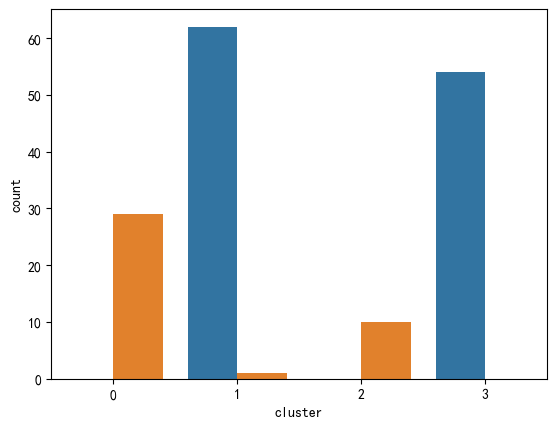

In [47]:
sns.countplot(
    x = 'cluster',
    hue = '汽车类别',
    data = df_result
)
# 从图中可以看出，聚类结果中的0,1两类是属于轿车的组别，2,3两类是属于卡车的组别

## 6.聚类效果的评估
### 6.1 肘部法（手肘法）

    找到随着K值变大时，损失函数的拐点位置
    损失函数：SSE / 距离
    计算每个K值下对应每个类别的所有点到中心点的距离和/距离的平方和，理论上来说，该值越小，聚类的效果就越好，但会发现，随着距离和/距离平方和下降，达到一定程度时，会出现拐点，此时拐点位置的聚类数量一般是比较合适的聚类数量，因为随着聚类数量趋近于样本数量，距离和/距离平方和会趋近于0，但这样的聚类结果没有意义。因此肘部法的主要目的是寻求K值变化的拐点而不是距离和/距离平方和最小  
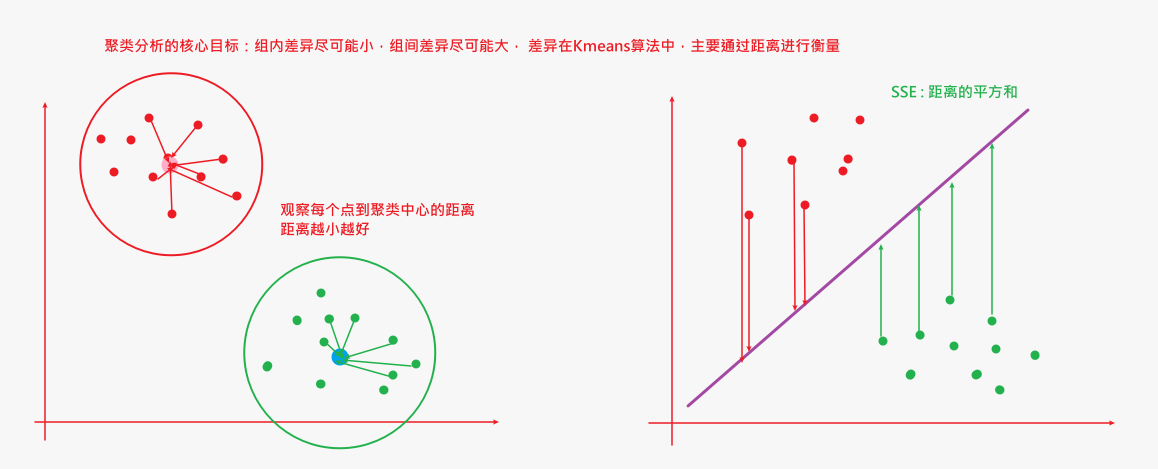    

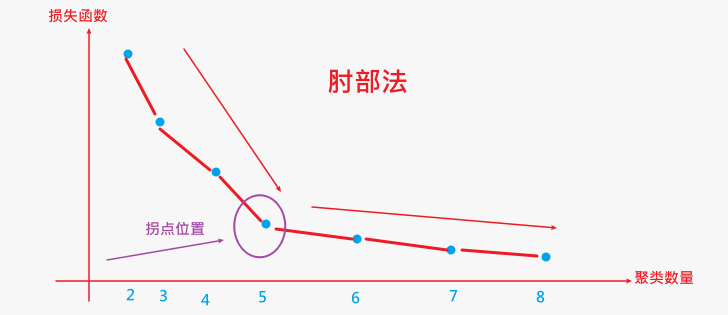

先通过Pipeline转换出用于聚类模型评估的标准化数据

In [ ]:
df_x = preprocessor.transform(df_km1)

In [ ]:
df_x
# 转换好的用来建模的标准化数据

array([[-1.21088853, -0.81298837, -0.82543881, ...,  0.97999536,
         2.29015886,  0.        ],
       [ 0.13358557,  0.69094938,  0.08045672, ...,  0.27267173,
         2.29015886,  0.        ],
       [ 0.13358557,  0.69094938, -0.07709033, ...,  0.50844627,
         2.29015886,  0.        ],
       ...,
       [-0.63468535, -0.31757358, -0.33966874, ...,  0.27267173,
         2.29015886,  0.        ],
       [-0.73071921,  0.88557662, -0.33966874, ..., -0.19887736,
         2.29015886,  0.        ],
       [-0.15451603,  0.26630813,  0.31677729, ...,  0.03689719,
         2.29015886,  0.        ]])

In [ ]:
df_x.shape

(156, 10)

In [ ]:
df_km1.head()

,汽车类别,发动机尺寸,马力,轴距,车宽,车长,整车重量,油箱容量,燃油效率
0,0.0,1.8,140.0,101.2,67.3,172.4,2.64,13.2,28.0
1,0.0,3.2,225.0,108.1,70.3,192.9,3.52,17.2,25.0
2,0.0,3.2,225.0,106.9,70.6,192.0,3.47,17.2,26.0
3,0.0,3.5,210.0,114.6,71.4,196.6,3.85,18.0,22.0
4,0.0,1.8,150.0,102.6,68.2,178.0,3.00,16.4,27.0


用可视化方式观察肘部法的距离和变化情况

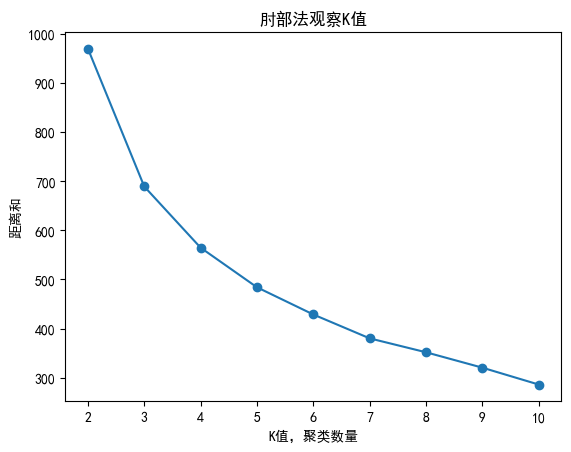

In [ ]:
s_inertia = []
# 总的距离和，存储聚类数量为2~10类时的距离和
for i in range(2,11):
    # 将数据分别聚为2到10类，观察其宗距离和变化情况
    km = KMeans(n_clusters = i, random_state = 100)
    km.fit(df_x)
    # 针对标准化之后的数据进行训练
    s_inertia.append(km.inertia_)
    # 将当前聚类结果的距离和添加到s_inertia中
# s_inertia
plt.plot(range(2,11), s_inertia, marker = 'o')
plt.xlabel('K值，聚类数量')
plt.ylabel('距离和')
plt.title('肘部法观察K值')
plt.show()

### 6.2 轮廓系数

    计算每个样本到同一组其他点的平均距离与该样本到其他组的点的平均距离的差异
    轮廓系数的取值范围在[-1,1]之间，越接近1，说明聚类的效果越好
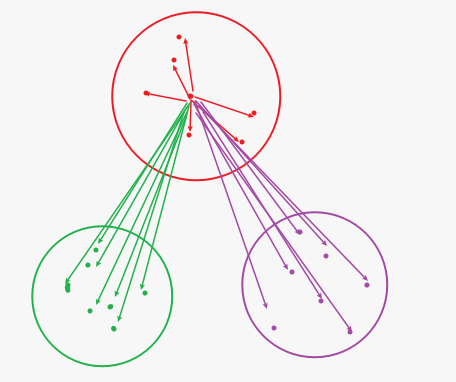   

从metrics中导入轮廓系数计算方法

In [ ]:
from sklearn.metrics import silhouette_score

通过可视化方式观察随聚类数量增加的轮廓系数变化情况

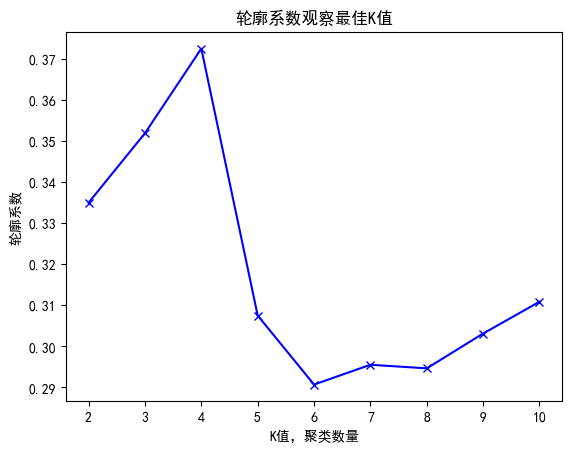

In [ ]:
ss = []
# 存储聚类数量为2~10类时的轮廓系数
for i in range(2,11):
    # 将数据分别聚为2到10类，观察其轮廓系数变化情况
    km = KMeans(n_clusters = i, random_state = 100)
    km.fit(df_x)
    # 针对标准化之后的数据进行训练
    ss.append(
        silhouette_score(
            df_x,
            km.labels_,
            metric = 'euclidean'  # 通过欧式距离计算轮廓系数
        )
    )
# ss
plt.plot(range(2,11), ss, 'bx-')
plt.xlabel('K值，聚类数量')
plt.ylabel('轮廓系数')
plt.title('轮廓系数观察最佳K值')
plt.show()

通过对肘部法变化的曲线和轮廓系数变化的曲线可以发现，当K值为4时，聚类效果比较理想

## 7.对4类的聚类结果进行分析，得到各类别的特点

In [48]:
df_result

,汽车类别,发动机尺寸,马力,轴距,车宽,车长,整车重量,油箱容量,燃油效率,cluster
0,0.0,1.8,140.0,101.2,67.3,172.4,2.64,13.2,28.0,1
1,0.0,3.2,225.0,108.1,70.3,192.9,3.52,17.2,25.0,3
2,0.0,3.2,225.0,106.9,70.6,192.0,3.47,17.2,26.0,3
3,0.0,3.5,210.0,114.6,71.4,196.6,3.85,18.0,22.0,3
4,0.0,1.8,150.0,102.6,68.2,178.0,3.00,16.4,27.0,1
...,...,...,...,...,...,...,...,...,...,...
151,0.0,1.9,160.0,100.5,67.6,176.6,3.04,15.8,25.0,1
152,0.0,2.4,168.0,104.9,69.3,185.9,3.21,17.9,25.0,1
153,0.0,2.4,168.0,104.9,69.3,186.2,3.26,17.9,25.0,1
154,0.0,2.3,236.0,104.9,71.5,185.7,3.60,18.5,23.0,3


<Axes: ylabel='count'>

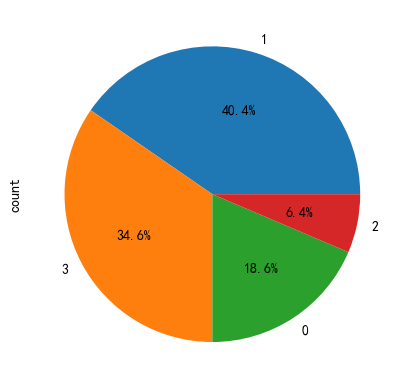

In [49]:
# 聚类结果的分布情况
df_result.cluster.value_counts().plot(kind = 'pie', autopct = '%.1f%%')

<Axes: xlabel='cluster', ylabel='发动机尺寸'>

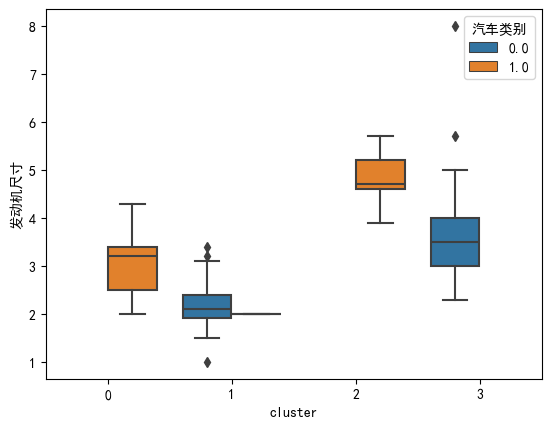

In [50]:
# 用分组的箱图观察聚类结果对每个技术指标（连续变量）的影响
sns.boxplot(
    x = 'cluster',
    y = '发动机尺寸',
    hue = '汽车类别',
    data = df_result
)

In [51]:
# 技术指标
df_result.columns[1:-1]

Index(['发动机尺寸', '马力', '轴距', '车宽', '车长', '整车重量', '油箱容量', '燃油效率'], dtype='object')

In [52]:
tech_features = list(df_result.columns[1:-1])
# 提取出所有的技术指标名称

In [53]:
tech_features

['发动机尺寸', '马力', '轴距', '车宽', '车长', '整车重量', '油箱容量', '燃油效率']

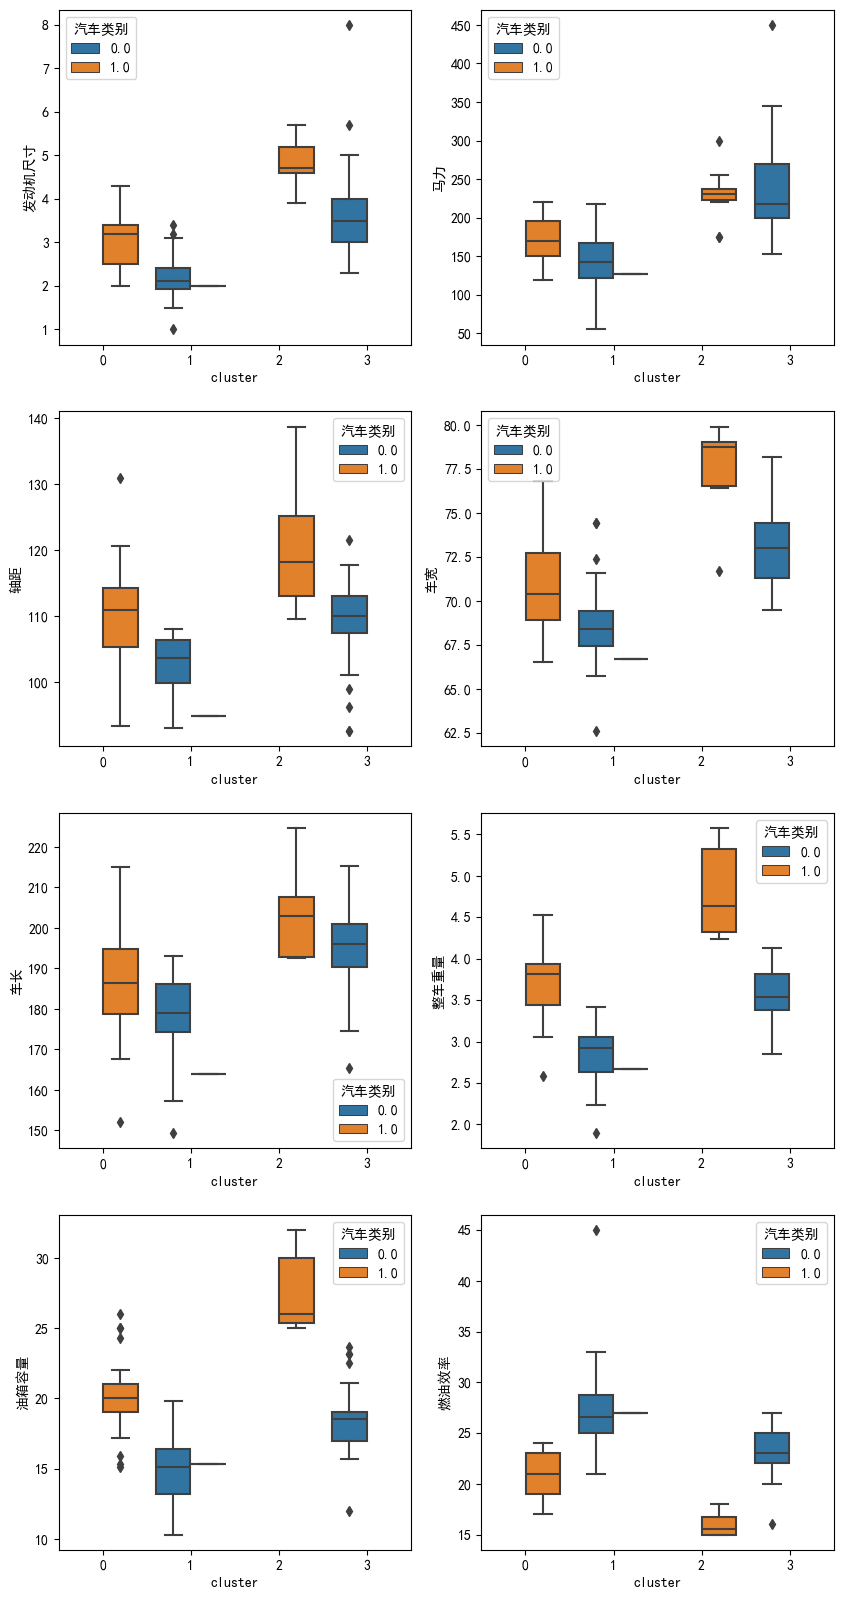

In [54]:
# 切割画布观察聚类结果对每个指标的影响，用汽车类别进行分组
plt.figure(figsize = (10,20))
for i in range(len(tech_features)):
    # 遍历每个技术指标的索引
    plt.subplot(len(tech_features) // 2, 2, i+1)
    # 将画布切割为n行2列，依次定位到每个axes
    sns.boxplot(
        x = 'cluster',
        y = tech_features[i],
        hue = '汽车类别',
        data = df_result
    )

从上述图像可以看出，除了燃油效率之外，其他指标上，类别1均高于类别0，类别2均高于类别3，结合汽车类别进行分析，可以认为，类别0属于低档轿车，类别1属于高档轿车，类别2属于高档卡车，类别3属于低档卡车

## 8.针对新车数据进行预测并分析对应的营销策略
### 8.1 利用构建好的聚类模型对新车型进行预测

提取新车的数据

In [55]:
df_car

,制造商,型号,销售（千辆）,4年转售价值,汽车类别,价格（千元）,发动机尺寸,马力,轴距,车宽,车长,整车重量,油箱容量,燃油效率,ln(销售),partition
0,Acura,Integra,16.92,16.36,0.0,21.50,1.8,140.0,101.2,67.3,172.4,2.64,13.2,28.0,2.83,0
1,Acura,TL,39.38,19.88,0.0,28.40,3.2,225.0,108.1,70.3,192.9,3.52,17.2,25.0,3.67,0
2,Acura,CL,14.11,18.23,0.0,NaN,3.2,225.0,106.9,70.6,192.0,3.47,17.2,26.0,2.65,0
3,Acura,RL,8.59,29.73,0.0,42.00,3.5,210.0,114.6,71.4,196.6,3.85,18.0,22.0,2.15,0
4,Audi,A4,20.40,22.26,0.0,23.99,1.8,150.0,102.6,68.2,178.0,3.00,16.4,27.0,3.02,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154,Volvo,V70,17.53,NaN,0.0,28.80,2.4,168.0,104.9,69.3,186.2,3.26,17.9,25.0,2.86,0
155,Volvo,C70,3.49,NaN,0.0,45.50,2.3,236.0,104.9,71.5,185.7,3.60,18.5,23.0,1.25,0
156,Volvo,S80,18.97,NaN,0.0,36.00,2.9,201.0,109.9,72.1,189.8,3.60,21.1,24.0,2.94,0
157,NaN,newCar,NaN,NaN,NaN,21.50,1.5,76.0,106.3,67.9,175.0,2.93,11.9,46.0,NaN,1


In [56]:
df_new_car = df_car.loc[df_car.partition == 1]
df_new_car

,制造商,型号,销售（千辆）,4年转售价值,汽车类别,价格（千元）,发动机尺寸,马力,轴距,车宽,车长,整车重量,油箱容量,燃油效率,ln(销售),partition
157,NaN,newCar,NaN,NaN,NaN,21.5,1.5,76.0,106.3,67.9,175.0,2.93,11.9,46.0,NaN,1
158,NaN,newTruck,NaN,NaN,NaN,34.2,3.5,167.0,109.8,75.2,188.4,4.51,17.2,26.0,NaN,1


填充新车型的汽车类别字段

In [57]:
df_new_car['汽车类别'].loc[df_new_car.型号 == 'newCar'] = 0
df_new_car['汽车类别'].loc[df_new_car.型号 == 'newTruck'] = 1

In [58]:
df_new_car

,制造商,型号,销售（千辆）,4年转售价值,汽车类别,价格（千元）,发动机尺寸,马力,轴距,车宽,车长,整车重量,油箱容量,燃油效率,ln(销售),partition
157,NaN,newCar,NaN,NaN,0.0,21.5,1.5,76.0,106.3,67.9,175.0,2.93,11.9,46.0,NaN,1
158,NaN,newTruck,NaN,NaN,1.0,34.2,3.5,167.0,109.8,75.2,188.4,4.51,17.2,26.0,NaN,1


利用训练好的KMeans模型进行预测

In [59]:
km_model_pipe.predict(df_new_car)

array([1, 0])

结合预测结果与聚类结果分析情况，可知newCar属于低档轿车，newTruck属于低档卡车

### 8.2 分析每类车型的定价策略

In [60]:
df_result
# 用来建模的数据集中没有价格

,汽车类别,发动机尺寸,马力,轴距,车宽,车长,整车重量,油箱容量,燃油效率,cluster
0,0.0,1.8,140.0,101.2,67.3,172.4,2.64,13.2,28.0,1
1,0.0,3.2,225.0,108.1,70.3,192.9,3.52,17.2,25.0,3
2,0.0,3.2,225.0,106.9,70.6,192.0,3.47,17.2,26.0,3
3,0.0,3.5,210.0,114.6,71.4,196.6,3.85,18.0,22.0,3
4,0.0,1.8,150.0,102.6,68.2,178.0,3.00,16.4,27.0,1
...,...,...,...,...,...,...,...,...,...,...
151,0.0,1.9,160.0,100.5,67.6,176.6,3.04,15.8,25.0,1
152,0.0,2.4,168.0,104.9,69.3,185.9,3.21,17.9,25.0,1
153,0.0,2.4,168.0,104.9,69.3,186.2,3.26,17.9,25.0,1
154,0.0,2.3,236.0,104.9,71.5,185.7,3.60,18.5,23.0,3


In [61]:
df_car

,制造商,型号,销售（千辆）,4年转售价值,汽车类别,价格（千元）,发动机尺寸,马力,轴距,车宽,车长,整车重量,油箱容量,燃油效率,ln(销售),partition
0,Acura,Integra,16.92,16.36,0.0,21.50,1.8,140.0,101.2,67.3,172.4,2.64,13.2,28.0,2.83,0
1,Acura,TL,39.38,19.88,0.0,28.40,3.2,225.0,108.1,70.3,192.9,3.52,17.2,25.0,3.67,0
2,Acura,CL,14.11,18.23,0.0,NaN,3.2,225.0,106.9,70.6,192.0,3.47,17.2,26.0,2.65,0
3,Acura,RL,8.59,29.73,0.0,42.00,3.5,210.0,114.6,71.4,196.6,3.85,18.0,22.0,2.15,0
4,Audi,A4,20.40,22.26,0.0,23.99,1.8,150.0,102.6,68.2,178.0,3.00,16.4,27.0,3.02,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154,Volvo,V70,17.53,NaN,0.0,28.80,2.4,168.0,104.9,69.3,186.2,3.26,17.9,25.0,2.86,0
155,Volvo,C70,3.49,NaN,0.0,45.50,2.3,236.0,104.9,71.5,185.7,3.60,18.5,23.0,1.25,0
156,Volvo,S80,18.97,NaN,0.0,36.00,2.9,201.0,109.9,72.1,189.8,3.60,21.1,24.0,2.94,0
157,NaN,newCar,NaN,NaN,NaN,21.50,1.5,76.0,106.3,67.9,175.0,2.93,11.9,46.0,NaN,1


为了观察每类车型的定价策略，需要将聚类结果的数据集和旧车型的数据集拼合起来

In [62]:
df_old_car

,制造商,型号,销售（千辆）,4年转售价值,汽车类别,价格（千元）,发动机尺寸,马力,轴距,车宽,车长,整车重量,油箱容量,燃油效率,ln(销售),partition
0,Acura,Integra,16.92,16.36,0.0,21.50,1.8,140.0,101.2,67.3,172.4,2.64,13.2,28.0,2.83,0
1,Acura,TL,39.38,19.88,0.0,28.40,3.2,225.0,108.1,70.3,192.9,3.52,17.2,25.0,3.67,0
2,Acura,CL,14.11,18.23,0.0,NaN,3.2,225.0,106.9,70.6,192.0,3.47,17.2,26.0,2.65,0
3,Acura,RL,8.59,29.73,0.0,42.00,3.5,210.0,114.6,71.4,196.6,3.85,18.0,22.0,2.15,0
4,Audi,A4,20.40,22.26,0.0,23.99,1.8,150.0,102.6,68.2,178.0,3.00,16.4,27.0,3.02,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152,Volvo,V40,3.55,NaN,0.0,24.40,1.9,160.0,100.5,67.6,176.6,3.04,15.8,25.0,1.27,0
153,Volvo,S70,15.25,NaN,0.0,27.50,2.4,168.0,104.9,69.3,185.9,3.21,17.9,25.0,2.72,0
154,Volvo,V70,17.53,NaN,0.0,28.80,2.4,168.0,104.9,69.3,186.2,3.26,17.9,25.0,2.86,0
155,Volvo,C70,3.49,NaN,0.0,45.50,2.3,236.0,104.9,71.5,185.7,3.60,18.5,23.0,1.25,0


In [63]:
df_old_car.iloc[[33]]

,制造商,型号,销售（千辆）,4年转售价值,汽车类别,价格（千元）,发动机尺寸,马力,轴距,车宽,车长,整车重量,油箱容量,燃油效率,ln(销售),partition
33,Chrysler,Town & Country,53.48,19.54,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.98,0


为了保证old_car和result的索引一致，要在old_car中删除索引为33的记录，并进行索引的重置

In [64]:
df_old = df_old_car.drop(33).reset_index(drop = True)

In [65]:
df_old

,制造商,型号,销售（千辆）,4年转售价值,汽车类别,价格（千元）,发动机尺寸,马力,轴距,车宽,车长,整车重量,油箱容量,燃油效率,ln(销售),partition
0,Acura,Integra,16.92,16.36,0.0,21.50,1.8,140.0,101.2,67.3,172.4,2.64,13.2,28.0,2.83,0
1,Acura,TL,39.38,19.88,0.0,28.40,3.2,225.0,108.1,70.3,192.9,3.52,17.2,25.0,3.67,0
2,Acura,CL,14.11,18.23,0.0,NaN,3.2,225.0,106.9,70.6,192.0,3.47,17.2,26.0,2.65,0
3,Acura,RL,8.59,29.73,0.0,42.00,3.5,210.0,114.6,71.4,196.6,3.85,18.0,22.0,2.15,0
4,Audi,A4,20.40,22.26,0.0,23.99,1.8,150.0,102.6,68.2,178.0,3.00,16.4,27.0,3.02,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,Volvo,V40,3.55,NaN,0.0,24.40,1.9,160.0,100.5,67.6,176.6,3.04,15.8,25.0,1.27,0
152,Volvo,S70,15.25,NaN,0.0,27.50,2.4,168.0,104.9,69.3,185.9,3.21,17.9,25.0,2.72,0
153,Volvo,V70,17.53,NaN,0.0,28.80,2.4,168.0,104.9,69.3,186.2,3.26,17.9,25.0,2.86,0
154,Volvo,C70,3.49,NaN,0.0,45.50,2.3,236.0,104.9,71.5,185.7,3.60,18.5,23.0,1.25,0


In [66]:
df_result.head()

,汽车类别,发动机尺寸,马力,轴距,车宽,车长,整车重量,油箱容量,燃油效率,cluster
0,0.0,1.8,140.0,101.2,67.3,172.4,2.64,13.2,28.0,1
1,0.0,3.2,225.0,108.1,70.3,192.9,3.52,17.2,25.0,3
2,0.0,3.2,225.0,106.9,70.6,192.0,3.47,17.2,26.0,3
3,0.0,3.5,210.0,114.6,71.4,196.6,3.85,18.0,22.0,3
4,0.0,1.8,150.0,102.6,68.2,178.0,3.00,16.4,27.0,1


In [67]:
# 建立聚类结果标签数组
labels = np.array(['低档轿车','高档轿车','高档卡车','低档卡车'])

In [68]:
pred_y

array([1, 3, 3, 3, 1, 3, 3, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 1, 1, 3,
       3, 3, 3, 1, 1, 3, 1, 1, 3, 1, 3, 3, 1, 1, 1, 3, 3, 2, 2, 2, 0, 2,
       0, 1, 3, 1, 3, 1, 3, 0, 0, 2, 0, 2, 1, 1, 0, 0, 0, 1, 1, 1, 3, 3,
       0, 0, 0, 3, 3, 3, 3, 2, 0, 3, 3, 2, 1, 1, 1, 3, 1, 0, 0, 1, 1, 3,
       3, 0, 0, 1, 3, 3, 3, 1, 1, 1, 3, 0, 1, 1, 3, 0, 0, 0, 0, 1, 3, 1,
       3, 0, 0, 1, 1, 0, 3, 1, 1, 3, 3, 3, 0, 1, 3, 3, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 3, 1, 0, 0, 1, 0, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       3, 3])

In [69]:
df_old.iloc[np.where(pred_y == 0)]

,制造商,型号,销售（千辆）,4年转售价值,汽车类别,价格（千元）,发动机尺寸,马力,轴距,车宽,车长,整车重量,油箱容量,燃油效率,ln(销售),partition
42,Dodge,Dakota,111.31,11.26,1.0,16.98,2.5,120.0,131.0,71.5,215.0,3.56,22.0,19.0,4.71,0
44,Dodge,Caravan,181.75,12.03,1.0,19.57,2.4,150.0,113.3,76.8,186.3,3.53,20.0,24.0,5.20,0
51,Ford,Explorer,276.75,16.64,1.0,31.93,4.0,210.0,111.6,70.2,190.7,3.88,21.0,19.0,5.62,0
52,Ford,Windstar,155.79,13.18,1.0,21.41,3.0,150.0,120.7,76.6,200.9,3.76,26.0,21.0,5.05,0
54,Ford,Ranger,220.65,7.85,1.0,12.05,2.5,119.0,117.5,69.4,200.7,3.09,20.0,23.0,5.40,0
58,Honda,CR-V,73.20,17.71,1.0,20.55,2.0,146.0,103.2,68.9,177.6,3.22,15.3,24.0,4.29,0
59,Honda,Passport,12.86,17.53,1.0,26.60,3.2,205.0,106.4,70.4,178.2,3.86,21.1,19.0,2.55,0
60,Honda,Odyssey,76.03,19.49,1.0,26.00,3.5,210.0,118.1,75.6,201.2,4.29,20.0,23.0,4.33,0
66,Jeep,Wrangler,55.56,13.48,1.0,14.46,2.5,120.0,93.4,66.7,152.0,3.05,19.0,17.0,4.02,0
67,Jeep,Cherokee,80.56,13.78,1.0,21.62,4.0,190.0,101.4,69.4,167.5,3.19,20.0,20.0,4.39,0


In [70]:
df_old['汽车档次'] = ''

将每个聚类结果对应的汽车档次添加到df_old中

In [71]:
for cluster in range(4):
    # 遍历每个聚类结果
    df_old.汽车档次.iloc[np.where(pred_y == cluster)] = labels[cluster]

In [72]:
df_old

,制造商,型号,销售（千辆）,4年转售价值,汽车类别,价格（千元）,发动机尺寸,马力,轴距,车宽,车长,整车重量,油箱容量,燃油效率,ln(销售),partition,汽车档次
0,Acura,Integra,16.92,16.36,0.0,21.50,1.8,140.0,101.2,67.3,172.4,2.64,13.2,28.0,2.83,0,高档轿车
1,Acura,TL,39.38,19.88,0.0,28.40,3.2,225.0,108.1,70.3,192.9,3.52,17.2,25.0,3.67,0,低档卡车
2,Acura,CL,14.11,18.23,0.0,NaN,3.2,225.0,106.9,70.6,192.0,3.47,17.2,26.0,2.65,0,低档卡车
3,Acura,RL,8.59,29.73,0.0,42.00,3.5,210.0,114.6,71.4,196.6,3.85,18.0,22.0,2.15,0,低档卡车
4,Audi,A4,20.40,22.26,0.0,23.99,1.8,150.0,102.6,68.2,178.0,3.00,16.4,27.0,3.02,0,高档轿车
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,Volvo,V40,3.55,NaN,0.0,24.40,1.9,160.0,100.5,67.6,176.6,3.04,15.8,25.0,1.27,0,高档轿车
152,Volvo,S70,15.25,NaN,0.0,27.50,2.4,168.0,104.9,69.3,185.9,3.21,17.9,25.0,2.72,0,高档轿车
153,Volvo,V70,17.53,NaN,0.0,28.80,2.4,168.0,104.9,69.3,186.2,3.26,17.9,25.0,2.86,0,高档轿车
154,Volvo,C70,3.49,NaN,0.0,45.50,2.3,236.0,104.9,71.5,185.7,3.60,18.5,23.0,1.25,0,低档卡车


针对价格进行分析

In [73]:
df_old.groupby('汽车档次')['价格（千元）'].describe()

,count,mean,std,min,25%,50%,75%,max
汽车档次,,,,,,,,
低档卡车,53.0,36.989057,17.278697,17.89,24.1500,31.51,43.3300,85.50
低档轿车,29.0,23.672759,6.158517,11.53,20.1000,22.53,26.9000,35.30
高档卡车,10.0,34.948000,14.663622,18.58,22.5675,31.54,45.3375,60.11
高档轿车,63.0,19.832381,7.770041,9.24,14.5950,17.50,23.0500,41.60


In [74]:
df_new_car

,制造商,型号,销售（千辆）,4年转售价值,汽车类别,价格（千元）,发动机尺寸,马力,轴距,车宽,车长,整车重量,油箱容量,燃油效率,ln(销售),partition
157,NaN,newCar,NaN,NaN,0.0,21.5,1.5,76.0,106.3,67.9,175.0,2.93,11.9,46.0,NaN,1
158,NaN,newTruck,NaN,NaN,1.0,34.2,3.5,167.0,109.8,75.2,188.4,4.51,17.2,26.0,NaN,1


从对旧车型的分析情况和新车型的价格来看，newCar的价位稍高于低档轿车的平均价格，但低于低档轿车价格的Q3，价格定位比较合理；newTruck的价位高于高档卡车的平均价格，接近低档卡车的最高价格，价格定位稍高了一些